# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from prettytable import PrettyTable
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.

data_path = '/home/monodeepdas112/Datasets/amazon-fine-food-reviews/database.sqlite'
con = sqlite3.connect(data_path)

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:16<00:00, 2754.81it/s]


In [23]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
# ## Similartly you can do preprocessing for review summary also.
# # Combining all the above stundents 
# from tqdm import tqdm
# preprocessed_review_summarys = []
# # tqdm is for printing the status bar
# for sentance in tqdm(final['Summary'].values):
#     sentance = re.sub(r"http\S+", "", sentance)
#     sentance = BeautifulSoup(sentance, 'lxml').get_text()
#     sentance = decontracted(sentance)
#     sentance = re.sub("\S*\d\S*", "", sentance).strip()
#     sentance = re.sub('[^A-Za-z]+', ' ', sentance)
#     # https://gist.github.com/sebleier/554280
#     sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
#     preprocessed_review_summarys.append(sentance.strip())

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
# #BoW
# count_vect = CountVectorizer() #in scikit-learn
# count_vect.fit(preprocessed_reviews)
# print("some feature names ", count_vect.get_feature_names()[:10])
# print('='*50)

# final_counts = count_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_counts))
# print("the shape of out text BOW vectorizer ",final_counts.get_shape())
# print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [26]:
# #bi-gram, tri-gram and n-gram

# #removing stop words like "not" should be avoided before building n-grams
# # count_vect = CountVectorizer(ngram_range=(1,2))
# # please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# # you can choose these numebrs min_df=10, max_features=5000, of your choice
# count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
# final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_bigram_counts))
# print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [27]:
# tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
# tf_idf_vect.fit(preprocessed_reviews)
# print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
# print('='*50)

# final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_tf_idf))
# print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentences=[]
for sentance in preprocessed_reviews:
    list_of_sentences.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=True
want_to_use_google_w2v = True
want_to_train_w2v = False

path_to_word2vec = '/home/monodeepdas112/Datasets/GoogleNews-vectors-negative300.bin.gz'

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentences,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile(path_to_word2vec):
        print('Preparing to load pre-trained Word2Vec model !')
        w2v_model=KeyedVectors.load_word2vec_format(path_to_word2vec, binary=True)
        print('Successfully loaded model into memory !!')
        print('Words similar to "similar" : ', w2v_model.wv.most_similar('great'))
        print('Words similar to "worst" : ',w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have google's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

Preparing to load pre-trained Word2Vec model !
Successfully loaded model into memory !!
Words similar to "similar" :  [('terrific', 0.798933207988739), ('fantastic', 0.7935212254524231), ('tremendous', 0.7748855948448181), ('wonderful', 0.7647868990898132), ('good', 0.7291510701179504), ('incredible', 0.7032873630523682), ('marvelous', 0.6971102952957153), ('phenomenal', 0.6841564178466797), ('amazing', 0.6634127497673035), ('awesome', 0.6510507464408875)]
Words similar to "worst" :  [('Worst', 0.6146091222763062), ('weakest', 0.6143776774406433), ('scariest', 0.5957258343696594), ('ugliest', 0.5931180119514465), ('best', 0.5835111141204834), ('bleakest', 0.5718506574630737), ('strongest', 0.5671455264091492), ('nastiest', 0.5644308924674988), ('lousiest', 0.5631451606750488), ('toughest', 0.5624396204948425)]


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [30]:
# # average Word2Vec
# # compute average word2vec for each review.
# sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance): # for each review/sentence
#     sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
#     cnt_words =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words:
#             vec = w2v_model.wv[word]
#             sent_vec += vec
#             cnt_words += 1
#     if cnt_words != 0:
#         sent_vec /= cnt_words
#     sent_vectors.append(sent_vec)
# print(len(sent_vectors))
# print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [31]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# model = TfidfVectorizer()
# tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [32]:
# # # TF-IDF weighted Word2Vec
# tfidf_feat = model.get_feature_names() # tfidf words/col-names
# # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
# row=0;
# for sent in tqdm(list_of_sentance): # for each review/sentence 
#     sent_vec = np.zeros(50) # as word vectors are of zero length
#     weight_sum =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words and word in tfidf_feat:
#             vec = w2v_model.wv[word]
# #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
#             # to reduce the computation we are 
#             # dictionary[word] = idf value of word in whole courpus
#             # sent.count(word) = tf valeus of word in this review
#             tf_idf = dictionary[word]*(sent.count(word)/len(sent))
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
#     if weight_sum != 0:
#         sent_vec /= weight_sum
#     tfidf_sent_vectors.append(sent_vec)
#     row += 1

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

In [33]:
#Getting the necessary imports and function definations
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import pprint
from sklearn.pipeline import Pipeline
import os.path
import pickle

### [5.0.0] Splitting up the Dataset into D_train and D_test

In [34]:
Dx_train, Dx_test, Dy_train, Dy_test = train_test_split(preprocessed_reviews[:50000], final['Score'].tolist()[:50000], test_size=0.20, random_state=42)

In [35]:
prettytable_data = []

### [5.0.1] Defining some functions to increase code reusability and readability

In [36]:
'''Creating Custom Vectorizers for TFIDF - W2Vec and Avg - W2Vec'''
class Tfidf_W2Vec_Vectorizer(object):
    def __init__(self, w2vec_model):
        self.tfidf = TfidfVectorizer(max_features=50)
        self.dictionary = None
        self.tfidf_feat = None
        
        self.word2vec = w2vec_model
        
    def fit(self, X, y):
        #Initializing the TFIDF Vectorizer
        self.tfidf.fit_transform(X)
        # we are converting a dictionary with word as a key, and the idf as a value
        self.dictionary = dict(zip(self.tfidf.get_feature_names(), list(self.tfidf.idf_)))
        self.tfidf_feat = self.tfidf.get_feature_names()
        
        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.dictionary[word]*(X.cout(word)/len(X))
                         for w in words if w in self.word2vec and w in self.tfidf_feat] or
                        [np.zeros(50)], axis=0)
                for words in X
            ])

class Avg_W2Vec_Vectorizer(object):
    def __init__(self, w2vec_model):
        self.word2vec = w2vec_model

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(50)], axis=0)
            for words in X
        ])

In [37]:
def get_vectorizer(vectorizer, w2vec_model=None):
    if(vectorizer=='BOW'):
        vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=300)
    if(vectorizer=='TFIDF'):
        vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=300)
    if(vectorizer=='TFIDF-W2Vec'):
        if(w2vec_model is None):
            raise Exception('TFIDF-W2Vec model is being used but W2Vec model is not passed as params')
        vectorizer = Tfidf_W2Vec_Vectorizer(w2vec_model)
    if(vectorizer=='Avg-W2Vec'):
        if(w2vec_model is None):
            raise Exception('Avg-W2Vec model is being used but W2Vec model is not passed as params')
        vectorizer = Avg_W2Vec_Vectorizer(w2vec_model)
    
    return vectorizer

In [38]:
'''Creation of Pipeline'''    
def create_KNN_pipeline(vectorizer, w2vec_model=None):
    steps = []
    steps.append((vectorizer, get_vectorizer(vectorizer, w2vec_model)))
    
    #Appending the KNN Classifier at the end of vectorization
    steps.append(('knn', KNeighborsClassifier()))
    return Pipeline(steps)

In [39]:
'''This function takes input the X, Y data and algorithm to use and 
model path (just to avoiding retraining an already trained model)
Performs GridSearchCV and returns the best parameters and cv_results_ 
data formatted as a pandas DataFrame'''
def perform_grid_search_cv(X, Y, algorithm, vectorizer, model_path, w2v):
    if(os.path.exists(model_path)):
        #if present simply load the model
        with open(model_path, 'rb') as input_file:
            clf = pickle.load(input_file)
    else:
        #if model not present then initialize --> perform cross validation --> save it to the above file path
        parameters_grid = {
            'knn__weights' : ['uniform','distance'],
            'knn__algorithm' : [algorithm],
            'knn__n_neighbors' : [5, 9, 15, 19, 23, 29, 35, 41, 51]
        }
        
        pipe = create_KNN_pipeline(vectorizer, w2v)
        clf = GridSearchCV(pipe, 
                           param_grid=parameters_grid, 
                           scoring='roc_auc', 
                           verbose=10, 
                           error_score='raise', 
                           cv = 5, 
                           iid=False, 
                           pre_dispatch='2',
                           return_train_score=True, n_jobs=-2)
        
        #Start to fit the model to get the best hyperparameters
        clf.fit(X, Y)
        try:
            #Save the model to the supplied model path 
            with open(model_path, 'wb') as output_file:
                pickle.dump(clf, output_file)
        except Exception as e:
            print(e)
        
    #Displaying the best parameters and best score acheived
    print('\n\nMaximum Area under ROC Curve with best params as : {0} \nwith the max area of {1}\n\n'.format(clf.best_params_, clf.best_score_))
    
    #Converting the cv_results to a pandas DataFrame
    cresults = pd.DataFrame(clf.cv_results_)
    cresults = pd.DataFrame(cresults.loc[:,['param_knn__n_neighbors', 
                                          'param_knn__weights', 
                                          'rank_test_score',                                            
                                          'mean_train_score', 
                                          'mean_test_score', 
                                          'std_train_score', 
                                          'std_test_score',]])
    return cresults, clf.best_params_, clf.best_score_

In [40]:
def analyse_results(df):
    #Sorting the dataframe as per 1-> best test scores then followed -> number of neighbours
    cresults = df
    cresults = cresults.sort_values(by=['rank_test_score', 'param_knn__n_neighbors'], ascending=[True, True])

    #seperating the dataframe by the weighing method to maintain uniformity of comparisions
    uniform_weighted = cresults[cresults['param_knn__weights']=='uniform']
    distance_weighted = cresults[cresults['param_knn__weights']=='distance']
    
    #plotting the uniform weighted measure K-NN results
    test_auc = uniform_weighted.mean_test_score
    test_auc_std = uniform_weighted.std_test_score
    plt.plot(uniform_weighted.param_knn__n_neighbors.tolist(), 
             test_auc, label='Validation AUC')
    plt.gca().fill_between(uniform_weighted.param_knn__n_neighbors.tolist(),
                          test_auc-test_auc_std, test_auc + test_auc_std, alpha=0.2, color='darkblue')
    
    train_auc = uniform_weighted.mean_train_score
    train_auc_std = uniform_weighted.std_train_score
    plt.plot(uniform_weighted.param_knn__n_neighbors.tolist(), 
             train_auc, label='Train AUC')
    plt.gca().fill_between(uniform_weighted.param_knn__n_neighbors.tolist(),
                          train_auc-train_auc_std, train_auc + train_auc_std, alpha=0.2, color='darkorange')
    plt.xlabel('n-neighbors')
    plt.ylabel('Area Under ROC Curve')
    plt.title('Area Under ROC Curve for K-NN with "uniform" distance metrics')
    plt.legend(loc='best')
    plt.show()

    
    #plotting the inverse-distance weighted measure K-NN results
    test_auc = distance_weighted.mean_test_score
    test_auc_std = distance_weighted.std_test_score
    plt.plot(distance_weighted.param_knn__n_neighbors.tolist(), 
             test_auc, label='Validation AUC')
    plt.gca().fill_between(distance_weighted.param_knn__n_neighbors.tolist(),
                          test_auc-test_auc_std, test_auc + test_auc_std, alpha=0.2, color='darkblue')
    
    train_auc = distance_weighted.mean_train_score
    train_auc_std = distance_weighted.std_train_score
    plt.plot(distance_weighted.param_knn__n_neighbors.tolist(), 
             distance_weighted.mean_train_score.tolist(), label='Train AUC')
    plt.gca().fill_between(distance_weighted.param_knn__n_neighbors.tolist(),
                          train_auc-train_auc_std, train_auc + train_auc_std, alpha=0.2, color='darkorange')
    plt.xlabel('n-neighbors')
    plt.ylabel('Area Under ROC Curve')
    plt.title('Area Under ROC Curve for K-NN with "inverse-distance" distance metrics')
    plt.legend(loc='best')
    plt.show()

In [41]:
def selecting_best_hyperparameters(df):
    
    #Selecting the max score and its corresponding characteristics
    cresults = df.sort_values(by=['rank_test_score', 'param_knn__n_neighbors'], ascending=[True, True])
    
    #Printing best 5 scores and their params
    print(cresults.iloc[0:15,:].to_string())

In [42]:
def plot_confusion_matrix(model, data, labels, dataset_label):
    pred = model.predict(data)
    conf_mat = confusion_matrix(labels, pred)
     
    strings = strings = np.asarray([['TN = ', 'TP = '],
                                    ['FN = ', 'FP = ']])

    labels = (np.asarray(["{0}{1}".format(string, value)
                          for string, value in zip(strings.flatten(),
                                                   conf_mat.flatten())])
             ).reshape(2, 2)

    fig, ax = plt.subplots()
    ax.set_title('Confusion Matrix : {0}'.format(dataset_label))
    sns.heatmap(conf_mat, annot=labels, fmt="", cmap='YlGnBu', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['False', 'True'])
    ax.set_yticklabels(['False', 'True'])
    plt.show()

In [43]:
def plot_AUC_ROC(knn, Dx_train, Dy_train, Dx_test, Dy_test):
    
    #predicting probability of Dx_test, Dx_train
    test_score = knn.predict_proba(Dx_test)
    train_score = knn.predict_proba(Dx_train)

    #Finding out the ROC_AUC_SCORE    
    train_roc_auc_score = roc_auc_score(Dy_train, train_score[:, 1])
    print('Area Under the Curve for Train : ', train_roc_auc_score)
    test_roc_auc_score = roc_auc_score(Dy_test, test_score[:, 1])
    print('Area Under the Curve for Test : ', test_roc_auc_score)

    #Plotting with matplotlib.pyplot
    #ROC Curve for D-train
    train_fpr, train_tpr, thresholds = roc_curve(Dy_train, train_score[:, 1])
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))

    # #ROC Curve for D-test
    test_fpr, test_tpr, thresholds = roc_curve(Dy_test, test_score[:, 1])
    plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
    
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("Area Under ROC Curve")
    plt.show()
    
    plot_confusion_matrix(mnb, vectorizer.transform(Dx_train), np.array(Dy_train), 'Training')
    plot_confusion_matrix(mnb, vectorizer.transform(Dx_test), np.array(Dy_test), 'Testing')

In [44]:
def retrain_with_best_hyperparameters(X, Y, best_params_):
    #Initializing the model with the selected best parameters from GridSearchCV
    knn = KNeighborsClassifier(algorithm = best_params_['knn__algorithm'], 
                               n_neighbors = best_params_['knn__n_neighbors'], 
                               weights = best_params_['knn__weights'], 
                               n_jobs=-1)
    
    #Training the model
    knn.fit(X, Y)
    return knn

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>



Maximum Area under ROC Curve with best params as : {'knn__algorithm': 'brute', 'knn__n_neighbors': 35, 'knn__weights': 'distance'} 
with the max area of 0.7805581887541058




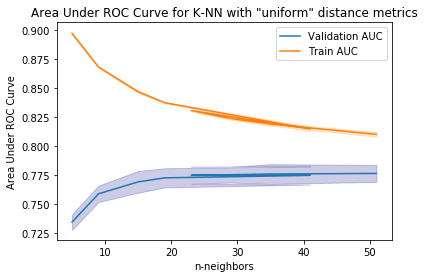

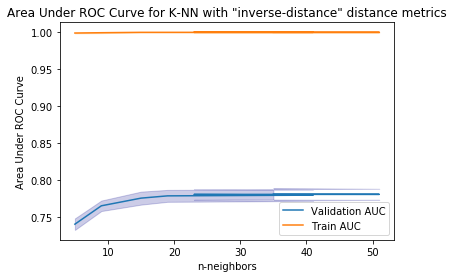

   param_knn__n_neighbors param_knn__weights  rank_test_score  mean_train_score  mean_test_score  std_train_score  std_test_score
13                     35           distance                1          0.999996         0.780558     5.138648e-07        0.008418
17                     51           distance                2          0.999996         0.780435     5.138648e-07        0.007486
11                     29           distance                3          0.999996         0.780389     5.138648e-07        0.006956
9                      23           distance                4          0.999996         0.780277     5.138648e-07        0.007290
15                     41           distance                5          0.999996         0.779330     5.138648e-07        0.007844
7                      19           distance                6          0.999996         0.778380     5.138648e-07        0.008081
16                     51            uniform                7          0.809865         0.

In [45]:
# Please write all the code with proper documentation
path = '/home/monodeepdas112/Notebooks/AI-Archives/saved-models/Assignment3/grid_search_cv_bow.pkl'

cresults, best_hyperparameters, best_score = perform_grid_search_cv(X=Dx_train, 
                                                        Y=Dy_train, 
                                                        algorithm='brute', 
                                                        vectorizer='BOW',
                                                        model_path=path, 
                                                        w2v=w2v_model)

# Analysing results
analyse_results(cresults)

# Selecting best hyperparameters
selecting_best_hyperparameters(cresults)

## [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>



Maximum Area under ROC Curve with best params as : {'knn__algorithm': 'brute', 'knn__n_neighbors': 15, 'knn__weights': 'distance'} 
with the max area of 0.6803624177065671




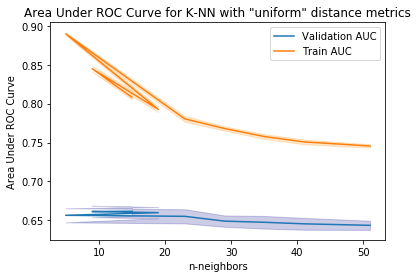

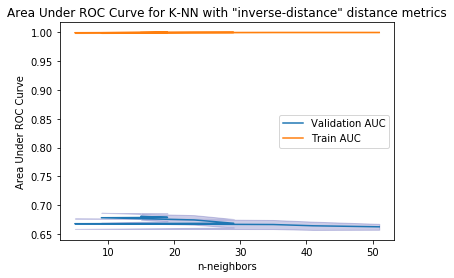

   param_knn__n_neighbors param_knn__weights  rank_test_score  mean_train_score  mean_test_score  std_train_score  std_test_score
5                      15           distance                1          0.999668         0.680362     6.545072e-04        0.005872
7                      19           distance                2          0.999996         0.678593     5.138648e-07        0.006733
3                       9           distance                3          0.999445         0.677960     6.847131e-04        0.008512
9                      23           distance                4          0.999996         0.674159     5.138648e-07        0.008318
11                     29           distance                5          0.999996         0.668344     5.138648e-07        0.007382
1                       5           distance                6          0.999476         0.667553     6.457357e-04        0.009046
13                     35           distance                7          0.999996         0.

In [46]:
# Please write all the code with proper documentation
path = '/home/monodeepdas112/Notebooks/AI-Archives/saved-models/Assignment3/grid_search_cv_tfidf.pkl'


cresults, best_hyperparameters, best_score = perform_grid_search_cv(X=Dx_train, 
                                                        Y=Dy_train, 
                                                        algorithm='brute',
                                                        vectorizer='TFIDF',
                                                        model_path=path, 
                                                        w2v=None)

# Analysing results
analyse_results(cresults)

# Selecting best hyperparameters
selecting_best_hyperparameters(cresults)

# #PrettyTable Data Collection
# prettytable_data.append(['TFIDF', best_hyperparameters['knn__algorithm'], best_hyperparameters['knn__n_neighbors'], best_score])

# #analysing the dataframe
# analyse_results(cresults)

# #Retrain with the best foud hyperparameters
# ##Initializing Vectorizer
# vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
# x_train = vectorizer.fit_transform(Dx_train)
# x_test = vectorizer.transform(Dx_test)
# #fitting the model
# knn = retrain_with_best_hyperparameters(X=x_train, Y=Dy_train, best_params_=best_hyperparameters)

# #Plot Area Under ROC Curve
# plot_AUC_ROC(knn, x_train, Dy_train, x_test, Dy_test)

# #Plotting confusion matrix x_train
# plot_confusion_matrix(knn, x_train, Dy_train, 'Training Data')
# #Plotting confusion matrix x_test
# plot_confusion_matrix(knn, x_test, Dy_test, 'Testing Data')

#### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [47]:
# Please write all the code with proper documentation
path = '/home/monodeepdas112/Notebooks/AI-Archives/saved-models/Assignment3/grid_search_cv_avg_w2v.pkl'
cresults, best_hyperparameters, best_score = perform_grid_search_cv(X=Dx_train, 
                                                        Y=Dy_train, 
                                                        algorithm='brute',
                                                        vectorizer='Avg-W2Vec',
                                                        model_path=path, w2v=w2v_model)

# Analysing results
analyse_results(cresults)

# Selecting best hyperparameters
selecting_best_hyperparameters(cresults)

# #PrettyTable Data Collection
# prettytable_data.append(['Avg-W2Vec', best_hyperparameters['knn__algorithm'], best_hyperparameters['knn__n_neighbors'], best_score])
# #analysing the dataframe
# analyse_results(cresults)

# #Retrain with the best foud hyperparameters
# ##Initializing Vectorizer
# vectorizer = Avg_W2Vec_Vectorizer()
# vectorizer.fit(Dx_train, Dy_train)
# x_train = vectorizer.transform(Dx_train)
# x_test = vectorizer.transform(Dx_test)
# #fitting the model
# knn = retrain_with_best_hyperparameters(X=x_train, Y=Dy_train, best_params_=best_hyperparameters)

# #Plot Area Under ROC Curve
# plot_AUC_ROC(knn, x_train, Dy_train, x_test, Dy_test)

# #Plotting confusion matrix x_train
# plot_confusion_matrix(knn, x_train, Dy_train, 'Training Data')
# #Plotting confusion matrix x_test
# plot_confusion_matrix(knn, x_test, Dy_test, 'Testing Data')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


OSError: [Errno 12] Cannot allocate memory

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
# Please write all the code with proper documentation
path = '/home/monodeepdas112/Notebooks/AI-Archives/saved-models/Assignment3/grid_search_cv_tf_idf_w2v.pkl'
cresults, best_hyperparameters, best_score = perform_grid_search_cv(X=Dx_train, 
                                                        Y=Dy_train, 
                                                        algorithm='brute', 
                                                        vectorizer='TFIDF-W2Vec',
                                                        model_path=path, w2v=w2v_model)

# Analysing results
analyse_results(cresults)

# Selecting best hyperparameters
selecting_best_hyperparameters(cresults)

# #PrettyTable Data Collection
# prettytable_data.append(['TFIDF-W2Vec', best_hyperparameters['knn__algorithm'], best_hyperparameters['knn__n_neighbors'], best_score])

# #analysing the dataframe
# analyse_results(cresults)

# #Retrain with the best foud hyperparameters
# ##Initializing Vectorizer
# vectorizer = Tfidf_W2Vec_Vectorizer()
# vectorizer.fit(Dx_train, Dy_train)
# x_train = vectorizer.transform(Dx_train)
# x_test = vectorizer.transform(Dx_test)
# #fitting the model
# knn = retrain_with_best_hyperparameters(X=x_train, Y=Dy_train, best_params_=best_hyperparameters)

# #Plot Area Under ROC Curve
# plot_AUC_ROC(knn, x_train, Dy_train, x_test, Dy_test)

# #Plotting confusion matrix x_train
# plot_confusion_matrix(knn, x_train, Dy_train, 'Training Data')
# #Plotting confusion matrix x_test
# plot_confusion_matrix(knn, x_test, Dy_test, 'Testing Data')

## [5.2] Applying KNN kd-tree

In [ ]:
Dx_train, Dx_test, Dy_train, Dy_test = train_test_split(preprocessed_reviews[20000], final['Score'].values[20000], test_size=0.20, random_state=42)

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [ ]:
# Please write all the code with proper documentation
path = 'saved_models/grid_search_cv_bow_kd.pkl'
cresults, best_hyperparameters, best_score = perform_grid_search_cv(X=Dx_train, 
                                                        Y=Dy_train, 
                                                        algorithm='kd_tree', 
                                                        vectorizer='BOW',
                                                        model_path=path)
#PrettyTable Data Collection
prettytable_data.append(['BOW-kd', best_hyperparameters['knn__algorithm'], best_hyperparameters['knn__n_neighbors'], best_score])

#Analysing the results
analyse_results(df=cresults)

#Retrain with the best foud hyperparameters
##Initializing Vectorizer
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
x_train = vectorizer.fit_transform(Dx_train)
x_test = vectorizer.transform(Dx_test)
#fitting the model
knn = retrain_with_best_hyperparameters(X=x_train, Y=Dy_train, best_params_=best_hyperparameters)

#Plot Area Under ROC Curve
plot_AUC_ROC(knn, x_train, Dy_train, x_test, Dy_test)

#Plotting confusion matrix x_train
plot_confusion_matrix(knn, x_train, Dy_train, 'Training Data')
#Plotting confusion matrix x_test
plot_confusion_matrix(knn, x_test, Dy_test, 'Testing Data')

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [ ]:
# Please write all the code with proper documentation
path = 'saved_models/grid_search_cv_tfidf_kd.pkl'
cresults, best_hyperparameters, best_score = perform_grid_search_cv(X=Dx_train, 
                                                        Y=Dy_train, 
                                                        algorithm='kd_tree', 
                                                        vectorizer='TFIDF',
                                                        model_path=path)


#PrettyTable Data Collection
prettytable_data.append(['TF-IDF-kd', best_hyperparameters['knn__algorithm'], best_hyperparameters['knn__n_neighbors'], best_score])

#analysing the dataframe
analyse_results(cresults)

#Retrain with the best foud hyperparameters
##Initializing Vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
x_train = vectorizer.fit_transform(Dx_train)
x_test = vectorizer.transform(Dx_test)
#fitting the model
knn = retrain_with_best_hyperparameters(X=x_train, Y=Dy_train, best_params_=best_hyperparameters)


#Plot Area Under ROC Curve
plot_AUC_ROC(knn, x_train, Dy_train, x_test, Dy_test)

#Plotting confusion matrix x_train
plot_confusion_matrix(knn, x_train, Dy_train, 'Training Data')
#Plotting confusion matrix x_test
plot_confusion_matrix(knn, x_test, Dy_test, 'Testing Data')

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
# Please write all the code with proper documentation
path = 'saved_models/grid_search_cv_avg_w2v_kd.pkl'

cresults, best_hyperparameters, best_score = perform_grid_search_cv(X=Dx_train, 
                                                        Y=Dy_train, 
                                                        algorithm='kd_tree', 
                                                        vectorizer='Avg-W2Vec',
                                                        model_path=path)

#PrettyTable Data Collection
prettytable_data.append(['Avg-W2Vec-kd', best_hyperparameters['knn__algorithm'], best_hyperparameters['knn__n_neighbors'], best_score])

#analysing the dataframe
analyse_results(cresults)


#Retrain with the best foud hyperparameters
##Initializing Vectorizer
vectorizer = Avg_W2Vec_Vectorizer()
vectorizer.fit(Dx_train, Dy_train)
x_train = vectorizer.transform(Dx_train)
x_test = vectorizer.transform(Dx_test)
#fitting the model
knn = retrain_with_best_hyperparameters(X=x_train, Y=Dy_train, best_params_=best_hyperparameters)

#Plot Area Under ROC Curve
plot_AUC_ROC(knn, x_train, Dy_train, x_test, Dy_test)

#Plotting confusion matrix x_train
plot_confusion_matrix(knn, x_train, Dy_train, 'Training Data')
#Plotting confusion matrix x_test
plot_confusion_matrix(knn, x_test, Dy_test, 'Testing Data')

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
# Please write all the code with proper documentation
path = 'saved_models/grid_search_cv_tf_idf_w2v_kd.pkl'
cresults, best_hyperparameters, best_score = perform_grid_search_cv(X=Dx_train, 
                                                        Y=Dy_train, 
                                                        algorithm='kd_tree',
                                                        vectorizer='TFIDF-W2Vec',
                                                        model_path=path)


#PrettyTable Data Collection
prettytable_data.append(['TFIDF-W2Vec-kd', best_hyperparameters['knn__algorithm'], best_hyperparameters['knn__n_neighbors'], best_score])

#analysing the dataframe
analyse_results(cresults)


#Retrain with the best foud hyperparameters
##Initializing Vectorizer
vectorizer = Tfidf_W2Vec_Vectorizer()
vectorizer.fit(Dx_train, Dy_train)
x_train = vectorizer.transform(Dx_train)
x_test = vectorizer.transform(Dx_test)
#fitting the model
knn = retrain_with_best_hyperparameters(X=x_train, Y=Dy_train, best_params_=best_hyperparameters)

#Plot Area Under ROC Curve
plot_AUC_ROC(knn, x_train, Dy_train, x_test, Dy_test)

#Plotting confusion matrix x_train
plot_confusion_matrix(knn, x_train, Dy_train, 'Training Data')
#Plotting confusion matrix x_test
plot_confusion_matrix(knn, x_test, Dy_test, 'Testing Data')

# [6] Conclusions

In [ ]:
# Please compare all your models using Prettytable library

In [ ]:
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper parameter", "AUC"]
[x.add_row(i) for i in prettytable_data]
print(x)

## TF-IDF Vectorizer seem to perform the best with the max AUC score of 0.87